## Data procesing
wiki + IMDB





In [0]:
!tar -xf wiki_crop.tar

In [0]:
import scipy.io
import os
import pandas as pd
import numpy as np
import cv2
from datetime import datetime

from numpy import asarray
from PIL import Image


mat = scipy.io.loadmat('./wiki_crop/wiki.mat')

instances = mat['wiki'][0][0][0].shape[1]
columns = ['dob', 'photo_taken', 'full_path', 'gender', "name", "face_location", "face_score", "second_face_score"]
df_wiki = pd.DataFrame(index=range(0, instances), columns=columns)
for i in mat:
  if i == "wiki":
    curr_array = mat[i][0][0]
    for j in range(len(curr_array)):
      df_wiki[columns[j]] = pd.DataFrame(curr_array[j][0])

In [0]:
mat = scipy.io.loadmat('./imdb_crop/imdb.mat')

instances_imdb = mat['imdb'][0][0][0].shape[1]
# columns = ['dob', 'photo_taken', 'full_path', 'gender', "name", "face_location", "face_score", "second_face_score"]
df_imdb = pd.DataFrame(index=range(0, instances_imdb), columns=columns)
for i in mat:
  if i == "imdb":
    curr_array = mat[i][0][0]
    print(len(curr_array))
    for j in range(0, len(curr_array)-2): #imdb has 10 columns
      df_imdb[columns[j]] = pd.DataFrame(curr_array[j][0])

In [0]:
 datetime.fromordinal(max(int(720044) - 366,1))

In [0]:
def cale_age(taken, dob):
  
  birth = datetime.fromordinal(max(int(dob) - 366,1))
  
  if birth.month < 7:
    return taken - birth.year
  else:
    return taken - birth.year - 1

df_wiki['age'] = [cale_age(df_wiki['photo_taken'][i], df_wiki['dob'][i]) for i in range(len(df_wiki['dob']))]
#df_imdb['age'] = [cale_age(df_imdb['photo_taken'][i], df_imdb['dob'][i]) for i in range(len(df_imdb['dob']))]

In [0]:
#clean data
#remove no face picture
df_wiki = df_wiki[df_wiki['face_score'] != -np.inf]
#remove more faces in one picuture
df_wiki = df_wiki[df_wiki['second_face_score'].isna()]
#threshold more than 3
df_wiki = df_wiki[df_wiki['face_score'] >= 3]
#remove no gender
df_wiki = df_wiki[df_wiki['gender'].isna()==False]
#reomve unuse columns
df_wiki = df_wiki.drop(columns=['name', 'face_score', 'second_face_score', 'face_location'])


In [0]:
#clean data
#remove no face picture
df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]
#remove more faces in one picuture
df_imdb = df_imdb[df_imdb['second_face_score'].isna()]
#threshold more than 3
df_imdb = df_imdb[df_imdb['face_score'] >= 3]
#remove no gender
df_imdb = df_imdb[df_imdb['gender'].isna()==False]
#reomve unuse columns
df_imdb = df_imdb.drop(columns=['name', 'face_score', 'second_face_score', 'face_location'])


In [0]:
df_wiki.head()

In [0]:
df_wiki = df_wiki[df_wiki['age']>0]
df_wiki = df_wiki[df_wiki['age']<=100]

# df_imdb = df_imdb[df_imdb['age']>0]
# df_imdb = df_imdb[df_imdb['age']<=100]

In [0]:
# df = df[df['age']>0]
# df = df[df['age']<=100]

In [0]:
target_size = (224,224)
#update to pixel value

def getImagetoPixels(image_path, db='wiki'): #db = wiki or imdb
  image = cv2.imread('{}_crop/{}'.format(db, image_path[0]), cv2.IMREAD_COLOR)
  image = cv2.resize(image,target_size)
#   print(db)
  return image.reshape(1,-1)[0]

In [0]:
# image = cv2.imread('./wiki_crop/00/10049200_1891-09-16_1958.jpg', cv2.IMREAD_COLOR)
# image = cv2.resize(image,target_size)
# image = getImagetoPixels(['00/10049200_1891-09-16_1958.jpg'])
# image.reshape(1,-1)[0]
df_wiki['pixels'] = df_wiki['full_path'].apply(getImagetoPixels)

In [0]:
df_imdb['pixels'] = df_imdb['full_path'].apply(getImagetoPixels)

In [0]:
# df = df_wiki.append(df_imdb, sort=False)

In [0]:
df = df_wiki

In [0]:
del df_wiki
# del df_imdb

In [0]:
df.shape #(115549, 6)

(22138, 6)

In [0]:
# from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, BatchNormalization, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Flatten, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.backend import mean
from keras.models import Model, Sequential
from keras.utils import plot_model, to_categorical
from keras.engine.topology import Network #for untrainable discrimator model but weight still is updated
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [0]:
target_classes = to_categorical(df['gender'].values, 2)

In [0]:
image_features = []
for i in range(0, df.shape[0]):
  image_features.append(df['pixels'].values[i])

In [0]:
from tempfile import mkdtemp
import os.path as path

filename_array = path.join(mkdtemp(), 'image_features_array.dat')
fp_image_features_array = np.memmap(filename_array, dtype='float32', mode='w+',\
                                    shape=(len(image_features), 224*224*3))

In [0]:
# for i in range(0, len(image_features)):
fp_image_features_array[:] = np.array(image_features[:])
#   print(i)

In [0]:
del image_features

In [0]:
fp_image_features_array.flush()
# fp_image_features_array.close()

In [0]:
fp_image_features_array.shape

In [0]:
# fp_image_features_array[:] = np.array(image_features)

In [0]:
# image_features = np.array(image_features)

In [0]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'imageFeaturefile.dat')
fp = np.memmap(filename, dtype='float32', mode='w+', shape=(fp_image_features_array.shape[0],224,224,3))

In [0]:
fp[:] = fp_image_features_array.reshape(fp_image_features_array.shape[0], 224, 224, 3)

In [0]:
# fp[:] = image_features.reshape(image_features.shape[0], 224, 224, 3)

In [0]:
fp[:] = fp/255

In [0]:
# from sklearn.utils import shuffle
# fp = shuffle(fp)

In [0]:
fp.shape[0] * 0.7

In [0]:
train_x_mp = path.join(mkdtemp(), 'train_x.dat')
train_x = np.memmap(train_x_mp, dtype='float32', mode='w+', shape=(int(fp.shape[0] * 0.7),224,224,3))

train_y_mp = path.join(mkdtemp(), 'train_y.dat')
train_y = np.memmap(train_y_mp, dtype='float32', mode='w+', shape=(int(fp.shape[0] * 0.7),2))

# test_x_mp = path.join(mkdtemp(), 'test_x.dat')
# test_x = np.memmap(test_x_mp, dtype='float32', mode='w+', shape=(int(fp.shape[0] * 0.3),224,224,3))

# test_y_mp = path.join(mkdtemp(), 'test_y.dat')
# test_y = np.memmap(test_y_mp, dtype='float32', mode='w+', shape=(int(fp.shape[0] * 0.3),2))

test_x_mp = path.join(mkdtemp(), 'test_x.dat')
test_x = np.memmap(test_x_mp, dtype='float32', mode='w+', shape=(6642,224,224,3))

test_y_mp = path.join(mkdtemp(), 'test_y.dat')
test_y = np.memmap(test_y_mp, dtype='float32', mode='w+', shape=(6642,2))

In [0]:
from sklearn.model_selection import train_test_split
train_x[:], test_x[:], train_y[:], test_y[:] = train_test_split(fp, target_classes, test_size=0.3)

In [0]:
test_x.shape

(6642, 224, 224, 3)

## Involving VGG FACE
https://github.com/rcmalli/keras-vggface.git

In [0]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-xc5t52fh
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-xc5t52fh
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=79aaab75a0532f95fc01f4cb6b4b5d579806191d270513a6fe0a7a31b2607bcf
  Stored in directory: /tmp/pip-ephem-wheel-cache-4k2jv9et/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from keras_vggface.vggface import VGGFace
vgg_model = VGGFace(include_top=False, model='vgg16', weights='vggface', input_shape=(224, 224, 3))

W0812 09:22:14.558366 139938199877504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 09:22:14.786098 139938199877504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 09:22:14.839571 139938199877504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 09:22:14.940340 139938199877504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58916864/58909280 [==============================] - 1s 0us/step


W0812 09:22:16.692734 139938199877504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 09:22:16.694360 139938199877504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
vgg_model.summary()

In [0]:
#add top layers
last_layer  = vgg_model.get_layer('pool5').output
for layer in vgg_model.layers:
  layer.trainable = False

x = Conv2D(4096, (7, 7), activation='relu')(last_layer)
x = Dropout(0.5)(x)
x = Conv2D(4096, (1, 1), activation='relu')(x)
x = Dropout(0.5)(x)
x = Conv2D(2, (1,1),name="prediction")(x) #for gender estimator

x = Flatten(name='flatten')(x)
output = Activation('softmax')(x)

facegender_vgg_model = Model(vgg_model.input, output)

W0812 09:22:20.182567 139938199877504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
facegender_vgg_model.compile(loss='categorical_crossentropy', \
                          optimizer=Adam(), \
                          metrics=['accuracy'])

W0812 09:22:20.546099 139938199877504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
for layer in facegender_vgg_model.layers:
    print(layer, layer.trainable)

In [0]:
checkpointer = ModelCheckpoint(filepath='gender_model.h5', \
                               monitor= 'val_loss', \
                               verbose=1, \
                               save_best_only=True,\
                               mode = 'auto'
                               )

In [0]:
loss_track = TensorBoard(log_dir='./face_gender_estimator_logs', histogram_freq=0, \
                            batch_size=256, \
                            write_graph=True,\
                            write_grads=False, \
                            write_images=False, \
                            embeddings_freq=0, \
                            embeddings_layer_names=None, \
                            embeddings_metadata=None,\
                            embeddings_data=None,\
                            update_freq='epoch')

In [0]:
epochs = 250
batch_size = 256
scores = []
for i in range(epochs):

  ix_train = np.random.choice(train_x.shape[0], size=batch_size)
  score = facegender_vgg_model.fit(train_x[ix_train], train_y[ix_train]
 , epochs=1, validation_data=(test_x, test_y), callbacks=[checkpointer])
  
  print(i)
  
  scores.append(score)

In [0]:
import time

time.ctime()

#10:30 ~ 15:14

'Mon Aug 12 15:13:58 2019'

In [0]:
# scores = []
# epochs = 256
# batch_size = 256
# # batch_train = np.random.choice(train_x.shape[0], size= batch_size)
# score = facegender_vgg_model.fit(train_x, train_y, \
#                               batch_size=128,\
#                               epochs=256,\
#                               validation_data=(test_x, test_y), \
#                               callbacks=[checkpointer, loss_track])
#   print(datetime.now())
#   scores.append(score)

In [0]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [0]:
# %tensorboard --logdir face_estimator_logs/

In [0]:
from keras.models import load_model
  
# gender_vgg_model_new = load_model("gender_model.h5")   
facegender_vgg_model.save_weights('gender_model_weights.h5')

In [0]:
cp ./gender_model.h5 ./drive/'My Drive'/Test_DATA/BestModel_estimator/

##Evaluation model

In [0]:
val_loss_change = []
loss_change = []
val_acc_process = []
acc_process = []

for i in range(0, len(scores)):
  val_loss_change.append(scores[i].history['val_loss'])
  loss_change.append(scores[i].history['loss'])
  val_acc_process.append(scores[i].history['val_acc'])
  acc_process.append(scores[i].history['acc'])
  
  

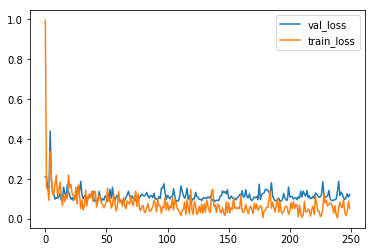

In [0]:
plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

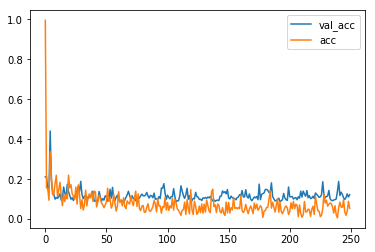

In [0]:
plt.plot(val_loss_change, label='val_acc')
plt.plot(loss_change, label='acc')
plt.legend(loc='upper right')
plt.show()

In [0]:
# facegender_vgg_model.evaluate(test_x, test_y, verbose=1)
gender_vgg_model_new.evaluate(test_x, test_y, verbose=1)

6642/6642 [==============================] - 83s 12ms/step


[0.08615934374402603, 0.9733514001088772]

In [0]:
len(test_x)

In [0]:
preditions = facegender_vgg_model.predict(test_x)


In [0]:
output_indexes = np.array([i for i in range(0, 2)])
apparent_predictions = np.sum(preditions * output_indexes, axis = 1)

In [0]:
MAE = 0
 
for i in range(0 ,apparent_predictions.shape[0]):
  prediction = int(apparent_predictions[i])
  actual = np.argmax(test_y[i])

  abs_error = abs(prediction - actual)
  MAE = MAE + abs_error

MAE = MAE / apparent_predictions.shape[0]
 
print("mae: ",MAE)
print("instances: ",apparent_predictions.shape[0])

mae:  0.37308039747064137
instances:  6642


In [0]:
from sklearn.metrics import classification_report, confusion_matrix
 
predictions = facegender_vgg_model.predict(test_x)
 
pred_list = []; actual_list = []
 
for pred in predictions:
   pred_list.append(np.argmax(pred))

for pred in test_y:
  actual_list.append(np.argmax(pred))

confusion_matrix(actual_list, pred_list)

array([[1781,  146],
       [  55, 4660]])

##Unit Test

In [0]:
#load image
# def load_image():
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [0]:
file = '009A11.JPG'
img = image.load_img(file, target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255

In [0]:
# for img_path in os.listdir('009A11.JPG'):
  img_array = cv2.imread('009A11.JPG')
  if img_array is not None:
      img = cv2.resize(img_array, (224,224))
      img = np.expand_dims(img, axis=0)
      img = img/255

In [0]:
pred = facegender_vgg_model.predict(img)

In [0]:
np.argmax(pred)

array([[0.9688572 , 0.03114283]], dtype=float32)

In [0]:
img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()
apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
print("apparent age: ", int(apparent_age[0]))